In [1]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "tasic_2018.h5ad"))
adata

AnnData object with n_obs × n_vars = 23178 × 45768 
    obs: 'cell_class', 'batch'
    uns: 'name', 'organism', 'tissue', 'year'

In [3]:
adata.obs.head()

,cell_class,batch
F2S4_150422_002_A01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_B01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_C01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_D01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_E01,Glutamatergic,Primary Visual Cortex (VISp)


In [4]:
adata.obs["labels"] = adata.obs["cell_class"]

### Load colors from manuscript

In [5]:
metadata = pd.read_csv(path.join("..", "data", "tasic_2018", "tasic-sample_heatmap_plot_data.csv"), index_col=0)
metadata.head()

,cluster_id,cluster_color,cluster_label,class_id,class_color,class_label,Gad2_log10_cpm,Slc17a7_log10_cpm,Lamp5_log10_cpm,Sncg_log10_cpm,Vip_log10_cpm,Sst_log10_cpm,Pvalb_log10_cpm
sample_name,,,,,,,,,,,,,
F1S4_161216_001_A01,94,#53D385,L5 PT ALM Slco2a1,2,#27AAE1,Glutamatergic,0.000000,2.703004,2.644231,0.000000,0.194593,0.0,0.000000
F1S4_180124_314_A01,73,#33A9CE,L5 IT ALM Npw,2,#27AAE1,Glutamatergic,0.000000,2.655333,3.254294,0.000000,0.000000,0.0,0.000000
F1S4_180124_315_A01,2,#FF88AD,Lamp5 Fam19a1 Pax6,1,#EF4136,GABAergic,2.981714,0.000000,0.000000,0.968798,0.000000,0.0,0.000000
F1S4_180124_315_B01,8,#9440F3,Sncg Slc17a8,1,#EF4136,GABAergic,2.479560,0.000000,0.000000,2.388210,0.000000,0.0,1.685995
F1S4_180124_315_C01,8,#9440F3,Sncg Slc17a8,1,#EF4136,GABAergic,2.881715,0.000000,0.000000,3.005049,0.000000,0.0,0.952222


In [6]:
adata_mask = adata.obs_names.isin(metadata.index)
adata = adata[adata_mask]
adata

View of AnnData object with n_obs × n_vars = 21874 × 45768 
    obs: 'cell_class', 'batch', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [7]:
adata.obs["cluster_color"] = metadata.loc[adata.obs_names.values, "cluster_color"]

Trying to set attribute `.obs` of view, copying.


## Preprocessing

In [8]:
sc.pp.filter_genes(adata, min_counts=10)
adata

AnnData object with n_obs × n_vars = 21874 × 40300 
    obs: 'cell_class', 'batch', 'labels', 'cluster_color'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 4.74
CPU times: user 7.14 s, sys: 3.66 s, total: 10.8 s
Wall time: 10.8 s


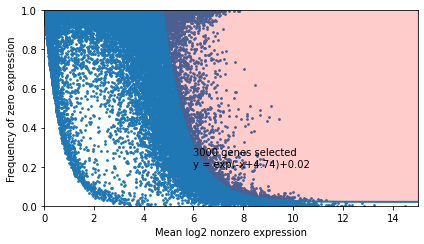

In [9]:
%time gene_mask = utils.select_genes(adata.X, n=3000, threshold=0)

In [10]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False)

In [11]:
adata.obsm["X_pca"] = utils.pca(adata.X[:, gene_mask])

## t-SNE Embeddings

In [12]:
init = openTSNE.initialization.rescale(adata.obsm["X_pca"][:, :2])

### Standard t-SNE

In [13]:
embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization=init,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


--------------------------------------------------------------------------------
TSNE(initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     metric='cosine', n_jobs=8, neighbors=None, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 6.10 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.54 seconds
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...
Iteration   50, KL divergence 5.1220, 50 iterations in 1.0531 sec
Iteration  100, KL divergence 4.3021, 50 iterations in 1.0435 sec
Iteration  150, KL divergence 4.0302, 50 it

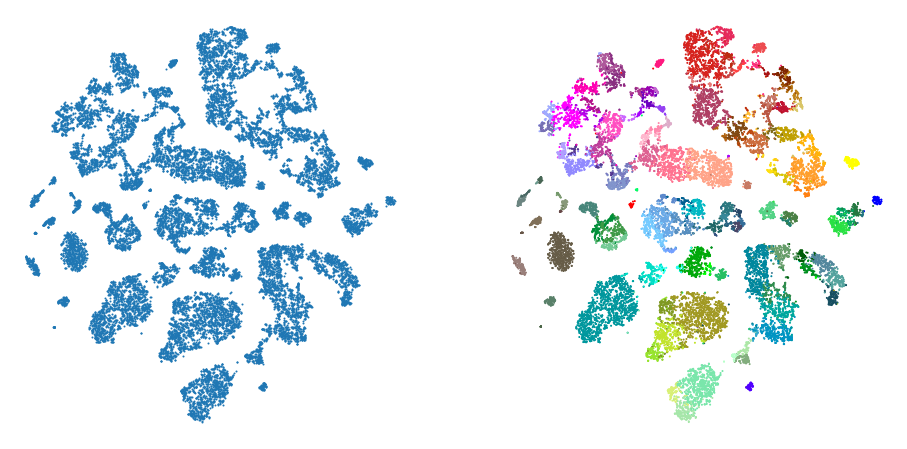

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_standard[:, 0], embedding_standard[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_standard[:, 0], embedding_standard[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

### perplexity=500

In [15]:
embedding_perp500 = openTSNE.TSNE(
    perplexity=500,
    initialization=init,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


--------------------------------------------------------------------------------
TSNE(initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     metric='cosine', n_jobs=8, neighbors=None, perplexity=500, random_state=0,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 22.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 7.20 seconds
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...
Iteration   50, KL divergence 2.6195, 50 iterations in 4.5805 sec
Iteration  100, KL divergence 2.0729, 50 iterations in 4.3828 sec
Iteration  150, KL 

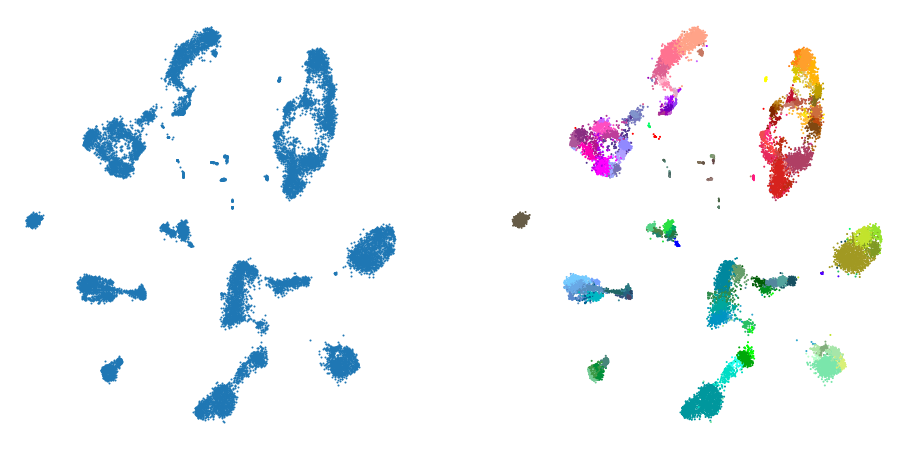

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_perp500[:, 0], embedding_perp500[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_perp500[:, 0], embedding_perp500[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

### multiscale=30,500

In [17]:
%%time
affinities = openTSNE.affinity.Multiscale(
    adata.obsm["X_pca"],
    perplexities=[30, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)
embedding_ms = openTSNE.TSNE(
    initialization=init,
    n_jobs=8,
    random_state=0,
    verbose=True,
    affinities=affinities,
).fit(adata.obsm["X_pca"])

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 21.42 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 15.94 seconds
--------------------------------------------------------------------------------
TSNE(affinities=<openTSNE.affinity.Multiscale object at 0x7fa7f8a007d0>,
     initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     n_jobs=8, neighbors=None, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...


/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Iteration   50, KL divergence 3.5812, 50 iterations in 4.5424 sec
Iteration  100, KL divergence 2.9411, 50 iterations in 4.4174 sec
Iteration  150, KL divergence 2.7799, 50 iterations in 4.3923 sec
Iteration  200, KL divergence 2.7037, 50 iterations in 4.5197 sec
Iteration  250, KL divergence 2.6567, 50 iterations in 4.4772 sec
   --> Time elapsed: 22.35 seconds
===> Running optimization with exaggeration=1.00, lr=1822.83 for 500 iterations...
Iteration   50, KL divergence 1.6553, 50 iterations in 4.3974 sec
Iteration  100, KL divergence 1.2923, 50 iterations in 4.4411 sec
Iteration  150, KL divergence 1.1219, 50 iterations in 4.3562 sec
Iteration  200, KL divergence 1.0240, 50 iterations in 4.7347 sec
Iteration  250, KL divergence 0.9606, 50 iterations in 4.7865 sec
Iteration  300, KL divergence 0.9173, 50 iterations in 5.4467 sec
Iteration  350, KL divergence 0.8857, 50 iterations in 5.4425 sec
Iteration  400, KL divergence 0.8626, 50 iterations in 5.6936 sec
Iteration  450, KL diver

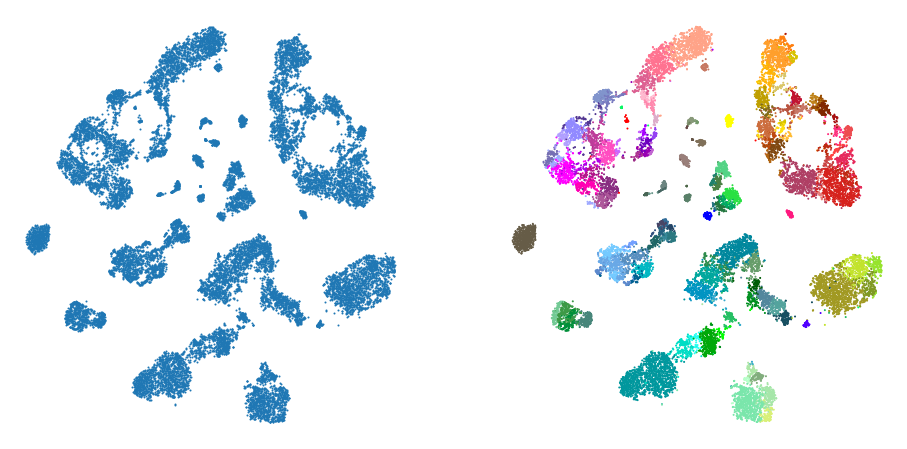

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_ms[:, 0], embedding_ms[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_ms[:, 0], embedding_ms[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

### dof=0.6

In [19]:
embedding_dof06 = openTSNE.TSNE(
    perplexity=30,
    initialization=init,
    metric="cosine",
    dof=0.6,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

--------------------------------------------------------------------------------
TSNE(dof=0.6,
     initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     metric='cosine', n_jobs=8, neighbors=None, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 7.22 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.50 seconds
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...
Iteration   50, KL divergence 5.4897, 50 iterations in 1.1746 sec
Iteration  100, KL divergence 4.8904, 50 iterations in 1.1160 sec
Iteration  150, KL divergence

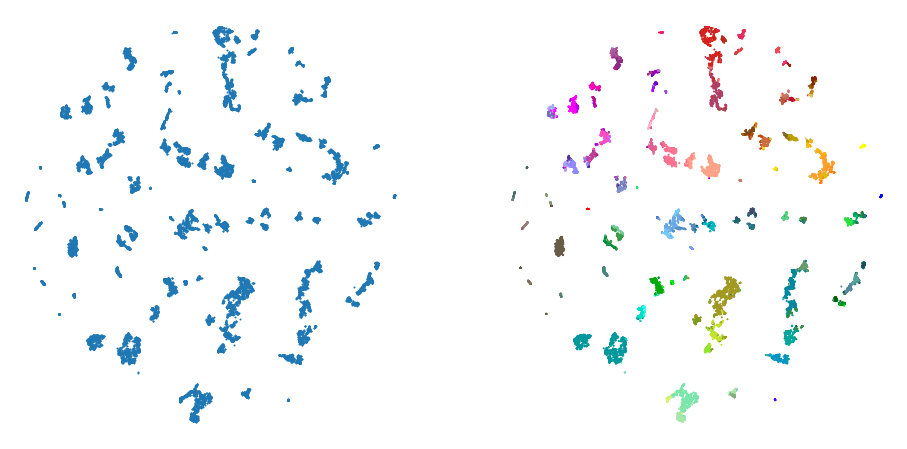

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_dof06[:, 0], embedding_dof06[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_dof06[:, 0], embedding_dof06[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

## Final figure

In [21]:
pd.DataFrame(embedding_standard, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/standard.csv")
pd.DataFrame(embedding_perp500, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/perp500.csv")
pd.DataFrame(embedding_ms, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/multiscale.csv")
pd.DataFrame(embedding_dof06, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/dof06.csv")

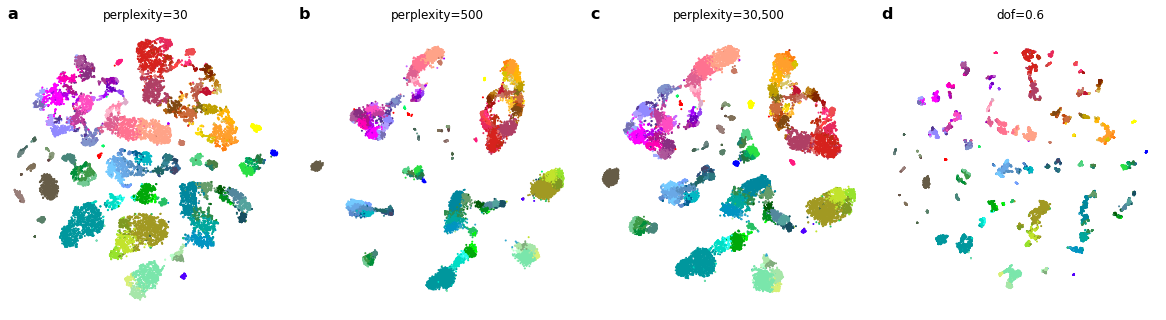

In [22]:
import string

fig, ax = plt.subplots(ncols=4, figsize=(16, 4))

for idx, (title, emb) in enumerate([
    ["perplexity=30", embedding_standard],
    ["perplexity=500", embedding_perp500],
    ["perplexity=30,500", embedding_ms],
    ["dof=0.6", embedding_dof06],
]):
    ax[idx].scatter(emb[:, 0], emb[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"], rasterized=True)
    ax[idx].set_title(title)

for ax_ in ax.ravel():
    ax_.axis("off")
    ax_.axis("equal")

for ax_, letter in zip(ax.ravel(), string.ascii_lowercase): 
    plt.text(0, 1.02, letter, transform=ax_.transAxes, fontsize=16, va="baseline", fontweight="bold")
    
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=1, bottom=0, left=0, right=1)

plt.savefig(path.join("..", "figures", "tasic2018.pdf"), dpi=300, bbox_inches="tight", transparent=True, width=16, height=4)